In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np

TensorFlow 2.x selected.


In [2]:
print(tf.__version__)

2.0.0


# Upload your dataset

In [23]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [36]:
!unzip -x "/content/gdrive/My Drive/2.project/남동발전(안전장비검출 프로젝트)/2.데이터셋관리/person_with_out_helmet.zip"

Archive:  /content/gdrive/My Drive/2.project/남동발전(안전장비검출 프로젝트)/2.데이터셋관리/person_with_out_helmet.zip
replace person_with_out_helmet/with_helmet/00062.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [24]:
data_dir = '/content/person_with_out_helmet'
print(data_dir)

/content/person_with_out_helmet


# Data pipeline

In [0]:
import os
class_list = os.listdir(data_dir)

In [26]:
label_to_ids = {}

for i, j in enumerate(class_list):
  label_to_ids[j] = i

print(label_to_ids)

{'with_helmet': 0, 'without_helmet': 1}


### 1. get filelist from directory structure

In [27]:
path_list = []
extension_check = []
for label in os.listdir(data_dir):
  print(label, ": ")
  each_class_image_path = os.path.join(data_dir, label)
  print(len(os.listdir(each_class_image_path)))
  for file in os.listdir(each_class_image_path):
    if file.split('.')[1] not in extension_check:
      extension_check.append(file.split('.')[1])
    path_list.append( os.path.join(each_class_image_path, file))

print('Kinds of extension : ', extension_check)
print(path_list[:2])
num_dataset = len(path_list)
print('The number of data : ', len(path_list))

with_helmet : 
3174
without_helmet : 
460
Kinds of extension :  ['jpg', 'bmp']
['/content/person_with_out_helmet/with_helmet/01944.jpg', '/content/person_with_out_helmet/with_helmet/02357.jpg']
The number of data :  3634


### 2. Define a function to process data individually

In [28]:
print(class_list)

['with_helmet', 'without_helmet']


In [0]:
[IMG_WIDTH, IMG_HEIGHT] = [128, 128]

BATCH_SIZE = 64

In [0]:
# build a lookup table
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(class_list[::-1]),
        values=tf.constant(list(range(len(class_list)))),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

In [31]:
input_tensor = tf.constant(['with_helmet', 'without_helmet', 'with_helmet', 'without_helmet'])
out = table.lookup(input_tensor)
print(out)

tf.Tensor([1 0 1 0], shape=(4,), dtype=int32)


In [0]:

def path_process(path):
  parts = tf.strings.split(path, '/')
  label = parts[-2] # The second to last is the class-directory
  return path, table.lookup(label)

def decode_img(path):
  img = tf.io.read_file(path)  
  if tf.strings.split(path, '.')[-1] == 'jpg':
    img = tf.image.decode_jpeg(img, channels=3)
  else:
    img = tf.image.decode_bmp(img, channels=3)
  
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])  

def data_process(path):
  filepath, label = path_process(path)
  img = tf.io.read_file(filepath)
  img = decode_img(filepath)
  return img, label

### 3. Make the datapipeline for taking mini-batches into your model

In [0]:
from random import shuffle
shuffle(path_list)

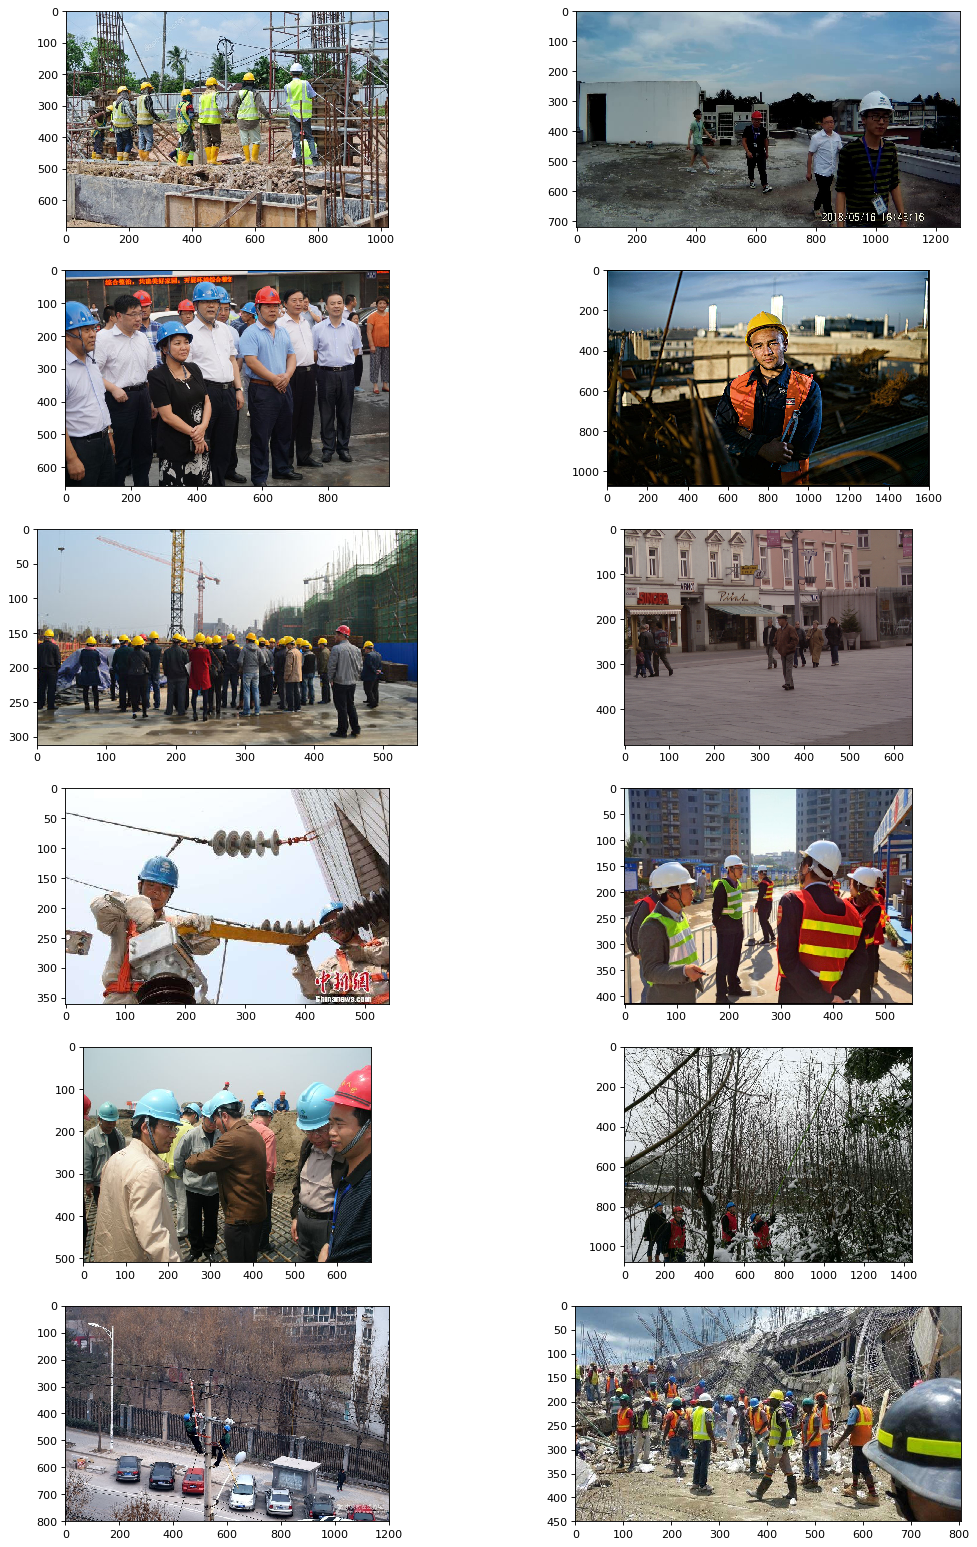

In [116]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(16, 25), dpi= 80)
axis = []
for i in range(12):
  axis.append(fig.add_subplot(6, 2, i+1))
  axis[i].imshow(plt.imread(path_list[i]))

plt.show()

In [107]:
help(fig.add_subplot)

Help on method add_subplot in module matplotlib.figure:

add_subplot(*args, **kwargs) method of matplotlib.figure.Figure instance
    Add an `~.axes.Axes` to the figure as part of a subplot arrangement.
    
    Call signatures::
    
       add_subplot(nrows, ncols, index, **kwargs)
       add_subplot(pos, **kwargs)
       add_subplot(ax)
    
    Parameters
    ----------
    *args
        Either a 3-digit integer or three separate integers
        describing the position of the subplot. If the three
        integers are *nrows*, *ncols*, and *index* in order, the
        subplot will take the *index* position on a grid with *nrows*
        rows and *ncols* columns. *index* starts at 1 in the upper left
        corner and increases to the right.
    
        *pos* is a three digit integer, where the first digit is the
        number of rows, the second the number of columns, and the third
        the index of the subplot. i.e. fig.add_subplot(235) is the same as
        fig.add_subpl

In [0]:
# Split your dataset into train and validation
train_path_list = path_list[:3000]
val_path_list = path_list[3000:]

In [0]:
def make_data_pipeline(path_list):
  list_ds = tf.data.Dataset.from_tensor_slices(path_list)
  processed_dataset = list_ds.map(data_process)
  data_pipeline = processed_dataset.shuffle(len(path_list)).batch(BATCH_SIZE)
  return data_pipeline

In [0]:
list_dataset = tf.data.Dataset.from_tensor_slices(path_list)

In [0]:
train_ds = make_data_pipeline(train_path_list)
val_ds = make_data_pipeline(val_path_list)

In [85]:
for images, labels in train_ds.take(1):
  print(labels)
  print(images.shape)

tf.Tensor(
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0], shape=(64,), dtype=int32)
(64, 128, 128, 3)


In [84]:
for images, labels in val_ds.take(1):
  print(labels)
  print(images.shape)

tf.Tensor(
[1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1
 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1], shape=(64,), dtype=int32)
(64, 128, 128, 3)


# Build model and Train it!

In [0]:
keras = tf.keras
layer = keras.layers

In [90]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.ResNet50V2(input_shape=[IMG_WIDTH, IMG_HEIGHT, 3],
                                            include_top=False,
                                            weights='imagenet')

94674944/94668760 [==============================] - 1s 0us/step


In [91]:
len(base_model.layers)

190

In [0]:
fine_tune_at = 175

In [93]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
# Fine tune from this layer onwards
# Freeze all the layers before the `fine_tune_at` layer

for l in base_model.layers[:fine_tune_at]:
    l.trainable = False

Number of layers in the base model:  190


In [0]:
inputs = keras.Input(shape=(128, 128, 3))
feature_batch = base_model(inputs)
global_average_layer = layer.GlobalAveragePooling2D()(feature_batch)
prediction = layer.Dense(1, activation='sigmoid')(global_average_layer)
model = keras.Model(inputs, prediction)

In [95]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet50v2 (Model)           (None, 4, 4, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 5,521,409
Non-trainable params: 18,045,440
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [97]:
import math
steps_per_epoch = math.ceil(3000 / BATCH_SIZE)

model.fit(train_ds, validation_data=val_ds, epochs = 5)

Epoch 1/5
47/47 [==============================] - 56s 1s/step - loss: 0.2243 - accuracy: 0.9137 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
47/47 [==============================] - 48s 1s/step - loss: 0.0236 - accuracy: 0.9937 - val_loss: 5.1038 - val_accuracy: 0.8659
Epoch 3/5
47/47 [==============================] - 49s 1s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.9739 - val_accuracy: 0.9006
Epoch 4/5
47/47 [==============================] - 48s 1s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.4305 - val_accuracy: 0.9022
Epoch 5/5
47/47 [==============================] - 48s 1s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.0986 - val_accuracy: 0.9054


In [100]:
model.evaluate(val_ds)

10/10 [==============================] - 9s 850ms/step - loss: 1.0954 - accuracy: 0.9054


[1.095396775007248, 0.9053628]

# Test your image individually

In [0]:
img, label = data_process('/content/person_with_out_helmet/without_helmet/person_070.bmp')

In [128]:
model.predict(tf.reshape(img, [1, 128, 128, 3]))

array([[0.00048406]], dtype=float32)

In [0]:
img, label = data_process('/content/person_with_out_helmet/with_helmet/02357.jpg')

In [130]:
model.predict(tf.reshape(img, [1, 128, 128, 3]))

array([[1.]], dtype=float32)